# ML Model Training Notebook
This notebook loads the synthetic dataset, performs train/test split, trains IsolationForest and RandomForest models, and evaluates metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/synthetic_timeseries.csv', parse_dates=['timestamp'])
df.head()

,timestamp,voltage,current,power,pf,freq,harmonics,anomaly,power_ma_5,power_std_5,current_diff_1,power_pct_change_1
0,2025-06-01 00:00:00,229.931,0.3688,84.795,0.980,49.995,0.00234,0,84.79500,0.000000,0.0000,0.000000
1,2025-06-01 00:01:00,230.505,0.3421,78.860,0.939,49.989,0.00924,0,81.82750,4.196679,-0.0267,-0.069992
2,2025-06-01 00:02:00,229.719,0.3179,73.033,0.956,49.982,0.01412,0,78.89600,5.881083,-0.0242,-0.073890
3,2025-06-01 00:03:00,230.299,0.3987,91.823,0.958,50.002,0.00515,0,82.12775,8.052013,0.0808,0.257281
4,2025-06-01 00:04:00,229.854,0.3371,77.484,0.987,50.000,0.01058,0,81.19900,7.275924,-0.0616,-0.156159


## Train/Test Split & Feature Selection

In [2]:
from sklearn.model_selection import train_test_split

feature_cols = [
    'voltage','current','power','pf','freq','harmonics',
    'power_ma_5','power_std_5','current_diff_1','power_pct_change_1'
]

X = df[feature_cols].fillna(0).values
y = df['anomaly'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((8400, 10), (3600, 10))

## IsolationForest (Unsupervised)

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

iso = IsolationForest(contamination=0.03, random_state=42, n_estimators=200)
iso.fit(X_train)

y_pred_iso = (iso.predict(X_test) == -1).astype(int)

iso_precision = precision_score(y_test, y_pred_iso, zero_division=0)
iso_recall = recall_score(y_test, y_pred_iso, zero_division=0)
iso_f1 = f1_score(y_test, y_pred_iso, zero_division=0)

iso_precision, iso_recall, iso_f1

(0.5289256198347108, 0.5714285714285714, 0.5493562231759657)

## RandomForest (Supervised)

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_precision = precision_score(y_test, y_pred_rf, zero_division=0)
rf_recall = recall_score(y_test, y_pred_rf, zero_division=0)
rf_f1 = f1_score(y_test, y_pred_rf, zero_division=0)

rf_precision, rf_recall, rf_f1

(0.9354838709677419, 0.7767857142857143, 0.848780487804878)

## Feature Importance (RandomForest)

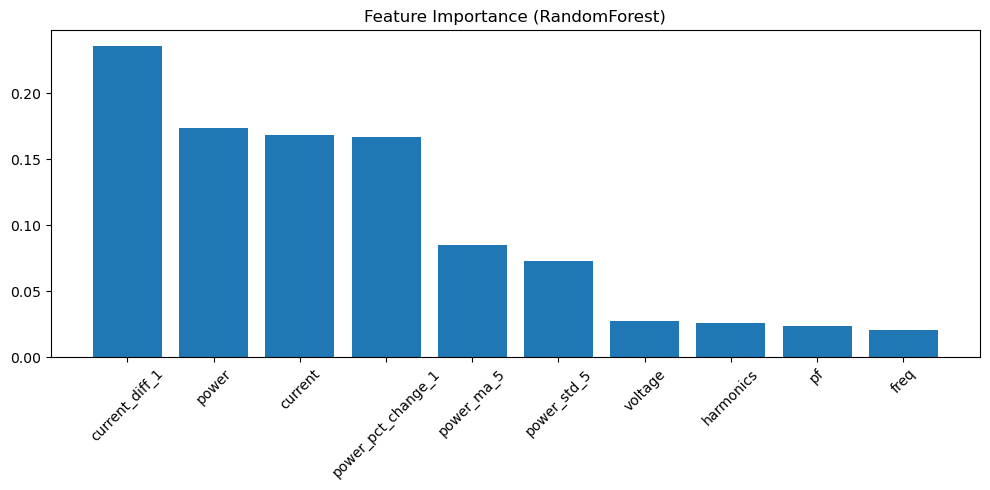

In [5]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(feature_cols)[indices], rotation=45)
plt.title("Feature Importance (RandomForest)")
plt.tight_layout()
plt.show()

## Save Models

In [6]:
import joblib, os

os.makedirs('../models', exist_ok=True)

joblib.dump(iso, '../models/isolation_forest_trained.joblib')
joblib.dump(rf, '../models/random_forest_trained.joblib')

"Models saved!" 

'Models saved!'